In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [4]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.2

year='2017'

In [5]:
indir = "outfiles/"
infiles = subprocess.getoutput("ls "+indir+year+"*.coffea").split()
outsum = processor.dict_accumulator()

# Check if pickle exists, remove it if it does                                                                             
picklename = str(year)+'/templates.pkl'
if os.path.isfile(picklename):
    os.remove(picklename)

started = 0
for filename in infiles:

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)

        if started == 0:
            outsum['templates'] = out['templates']
            outsum['sumw'] = out['sumw']
            started += 1
        else:
            outsum['templates'].add(out['templates'])
            outsum['sumw'].add(out['sumw'])
    
        del out

Loading outfiles/2017_dask_bsm.coffea


In [6]:
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates'].scale(scale_lumi, 'dataset')

templates = outsum['templates'].group('dataset', hist.Cat('process', 'Process'), pmap)

In [7]:
templates

<Hist (process,region,genflavor,pt1,msd1,ddb1) instance at 0x7fe48e4ee490>

In [10]:
msdhist_ddbpass = templates.integrate('region','signal').sum('genflavor','msd1').integrate('ddb1',int_range=slice(0.64,1))

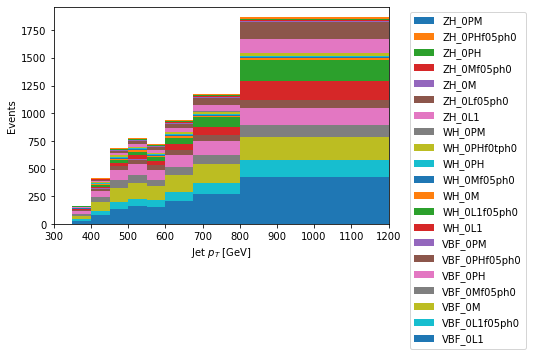

In [17]:
hist.plot1d(msdhist_ddbpass,stack='process')
plt.legend(bbox_to_anchor=(1.05,1))

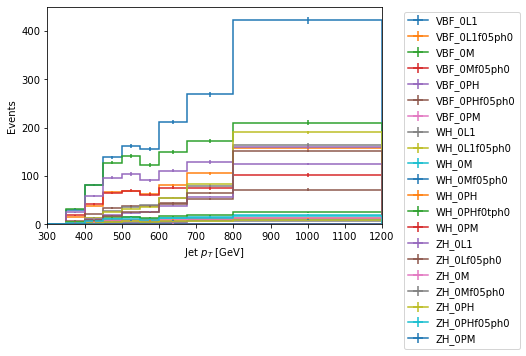

In [18]:
hist.plot1d(msdhist_ddbpass,overlay='process')
plt.legend(bbox_to_anchor=(1.05,1))